In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,4]
mpl.rcParams['figure.dpi'] = 350
mpl.rcParams['savefig.dpi'] = 350

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# function to take global weighted mean, just surface
def global_mean_2D(var, weights):
    # assumes 2D field as var input

    # make sure masking is correct, otherwise we get nans
    var = np.ma.masked_invalid(var)
    
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros(var.shape[0])

    # loop over time
    for t in np.arange(var.shape[0]):
        ave[t] = np.ma.average(var[t,:,:], weights = weights)
    return ave
# function to take global weighted mean, keeping depth information
def global_mean_3D(var, weights):
    # make sure masking is correct, otherwise we get nans
    var = np.ma.masked_invalid(var)
    
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros([var.shape[0], var.shape[1]])

    # loop over time
    for t in np.arange(var.shape[0]):
    # loop over each depth slice
        for d in np.arange(var.shape[1]):
            ave[t,d] = np.ma.average(var[t,d,:,:], weights = weights)
    return ave

In [12]:
dates_UR = pd.date_range(start = '01/31/2020', end = '12/31/2049', freq='M')
dates_c = pd.date_range(start = '01/31/2016', end = '6/30/2041', freq='M')
war_date  = pd.date_range(start = '05/15/2020', end = '5/31/2020', freq='d')
#dates_com = pd.date_range(start = '01/31/2018', end = '12/31/2034', freq='M')
dates_com = pd.date_range(start = '01/31/2018', end = '12/31/2049', freq='M')

In [4]:
file = '/glade/u/home/chsharri/Work/NW/nw_ur_150_07.pop.h.NO3.nc'
var_UR = xr.open_dataset(file, decode_times=False)

file = '/glade/u/home/chsharri/Work/NW/nw_cntrl_03.pop.h.NO3.nc'
var_c = xr.open_dataset(file, decode_times=False)

mask= xr.open_dataset('/glade/u/home/chsharri/Work/NW/region_mask_nw.nc')

In [6]:
z_t = var_c.z_t

In [7]:
ave_c = global_mean_3D(var_c.NO3,weights = mask.TAREA)  
ave_UR = global_mean_3D(var_UR.NO3,weights = mask.TAREA) 

In [8]:
global_comb = np.concatenate((ave_c[12*2:12*4],ave_UR), axis = 0)

In [9]:
file = '/glade/u/home/chsharri/Work/NW/nw_cntrl_03.pop.h.XMXL.nc'
XMXL_c = xr.open_dataset(file, decode_times=False)

file = '/glade/u/home/chsharri/Work/NW/nw_ur_150_07.pop.h.XMXL.nc'
XMXL_UR = xr.open_dataset(file, decode_times=False)

In [10]:
mld_UR = global_mean_2D(XMXL_UR.XMXL,weights = mask.TAREA)/100 
mld_c = global_mean_2D(XMXL_c.XMXL,weights = mask.TAREA)/100 

In [11]:
mld_comb = np.concatenate((mld_c[12*2:12*4],mld_UR), axis = 0)

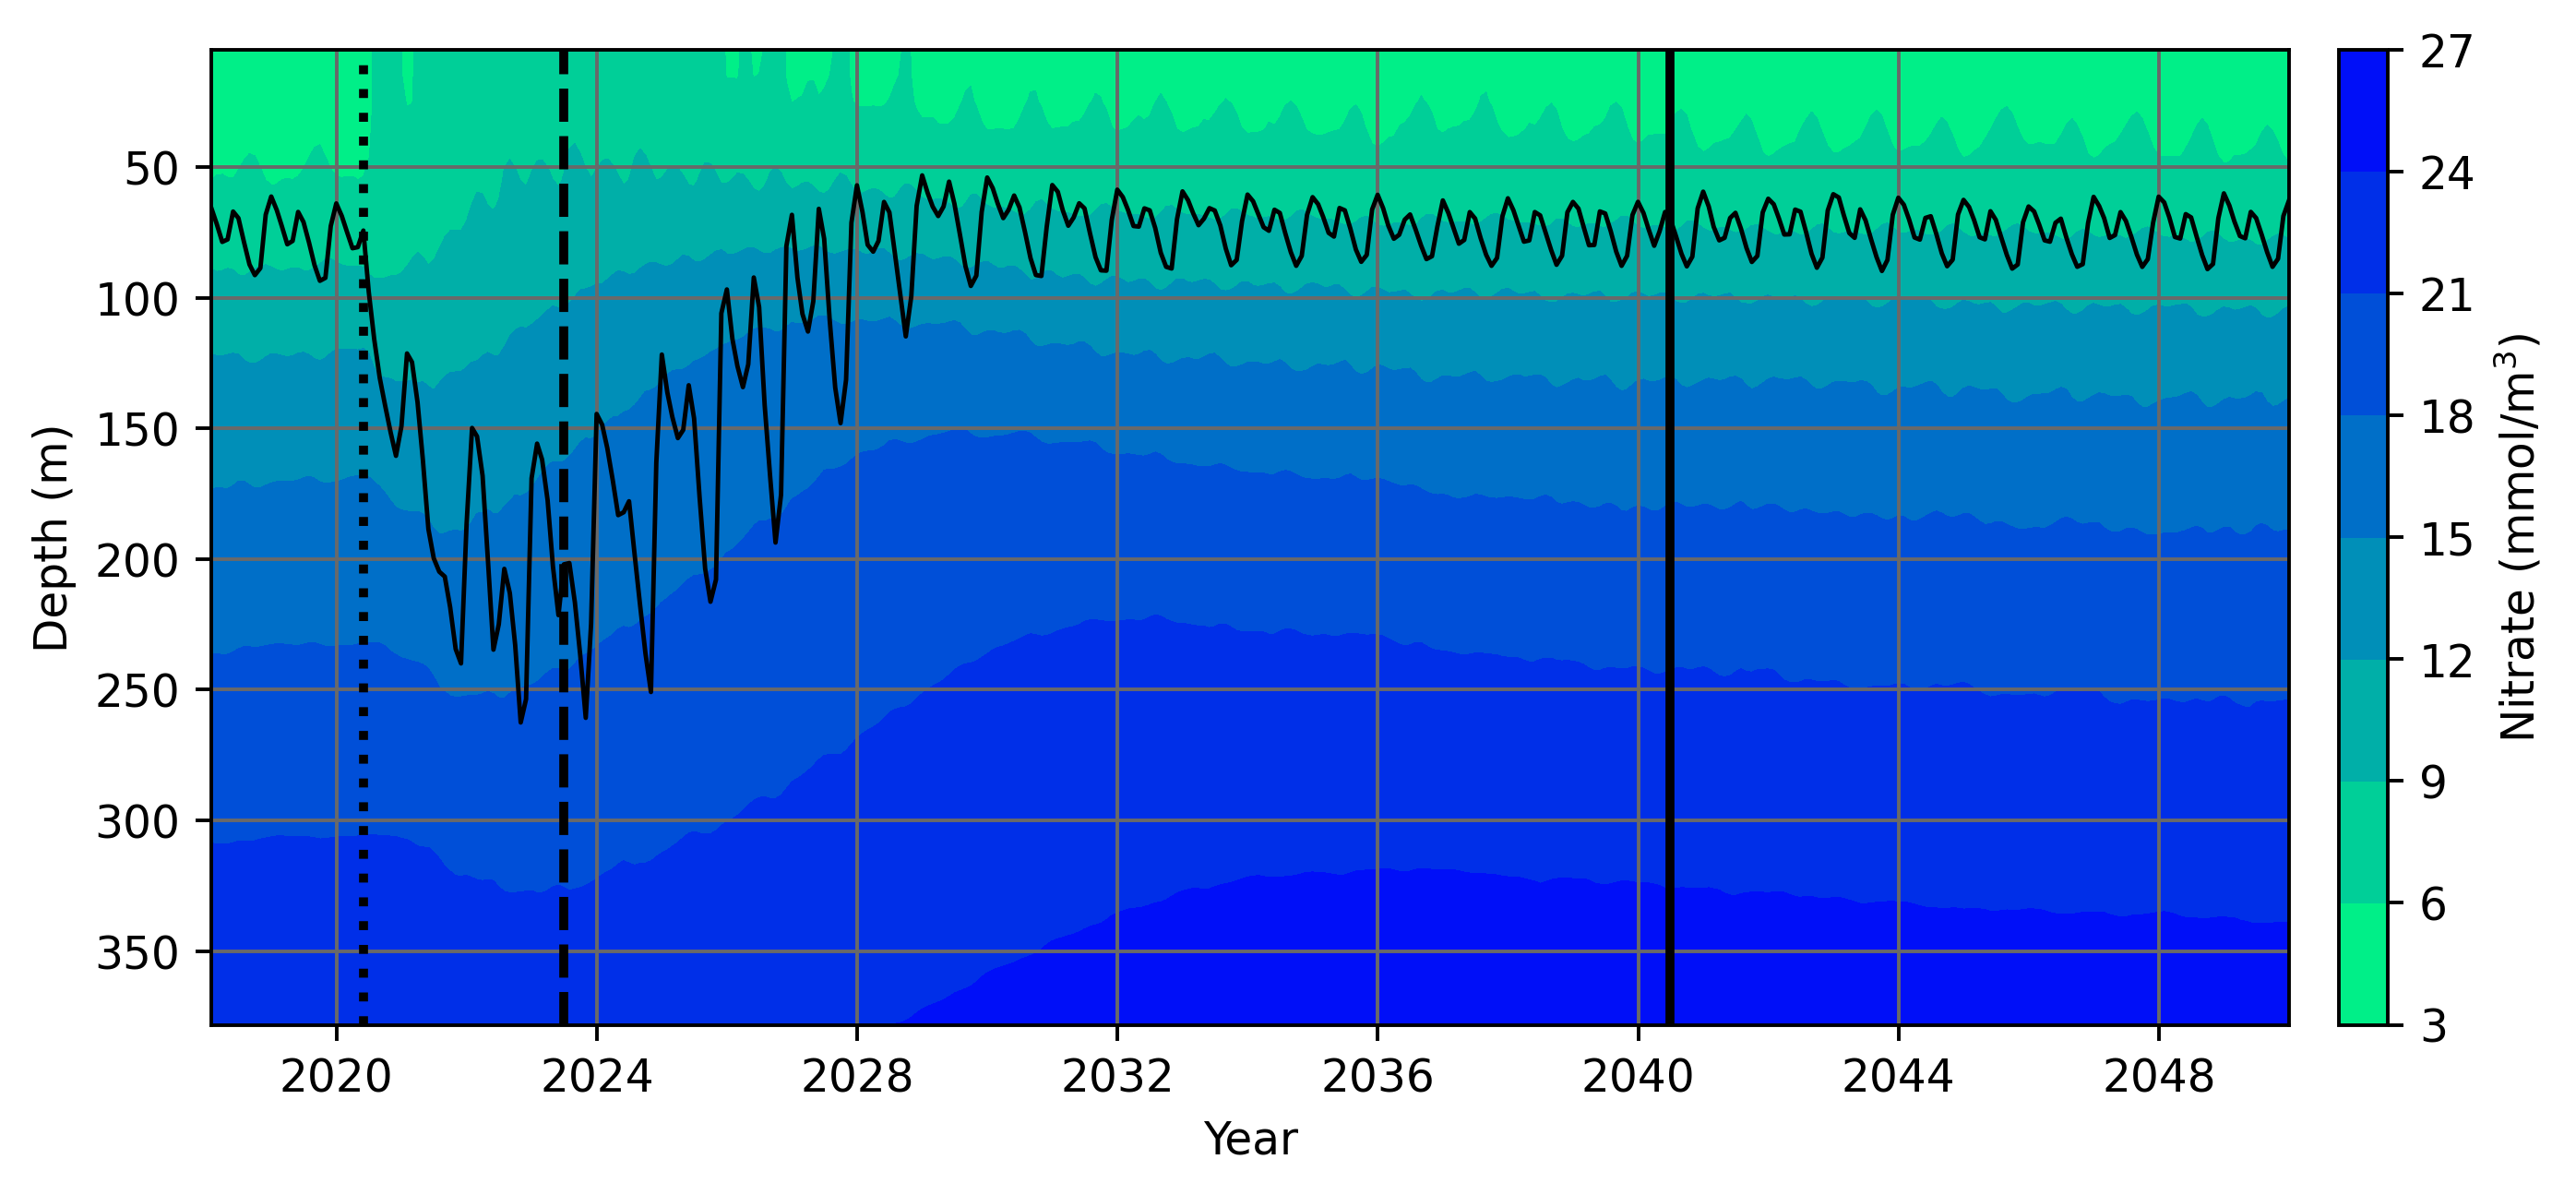

In [13]:
depthi = 30
fig= plt.figure(figsize=(10,4), facecolor='w')
clmap = 'winter_r'

var = global_comb

plt.contourf(dates_com, z_t[0:depthi]*0.01, np.transpose(var[:,0:depthi]), cmap = clmap)
cl = plt.colorbar(pad = 0.02)
cl.set_label('Nitrate (${\mathrm{mmol/m^3}}$)')

plt.ylabel('Depth (m)')
plt.xlabel('Year')

plt.plot([war_date[-1],war_date[-1]],[z_t[depthi-1]*0.01, z_t[0]*0.01],':', c = 'black', linewidth = 2)
date= pd.to_datetime('06/30/2023')
plt.plot([date, date],[z_t[depthi-1]*0.01, z_t[0]*0.01],'--', c = 'black', linewidth = 2 )
date= pd.to_datetime('06/30/2040')
plt.plot([date, date],[z_t[depthi-1]*0.01, z_t[0]*0.01],'-', c = 'black', linewidth = 2)



plt.grid(color = 'dimgrey')

plt.plot(dates_com,mld_comb, color = 'black', linewidth = 1)

plt.gca().invert_yaxis()

plt.show()
#fig.savefig('/glade/work/vgarza/nw_figures/water-column-XMXL for Nitrate no negative x.jpg' , bbox_inches='tight')
plt.close()